# BERT
<br> </br>

Here we are going to try another implementation of BERT, using the HuggingFace API [see here](https://huggingface.co/transformers/main_classes/trainer.html).
<br></br>
To download our dataset, [see here](https://drive.google.com/file/d/1o1BMTTU9YNPATL8x93l0N-h6sTZxLyDo/view?usp=sharing).

## Imports

In [ ]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-ymxft56_
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-ymxft56_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 870kB 7.8MB/s 
     |████████████████████████████████| 3.3MB 12.5MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2112159 sha256=9318a45296400138a4d85000c125a817d78054efa4a987eed6acd24adb36ad6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-32nlaofa/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=d17c11a477f04eb13cd260b1968603a562e893c5a9c1754232e28f6cf025d2a9
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f44836674465432

In [ ]:
#!pip install transformers
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union
import pandas as pd
import numpy as np
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns

import os

from transformers.utils import *
from transformers.data.data_collator import DataCollator, DataCollatorWithPadding, default_data_collator
from transformers.file_utils import (
    WEIGHTS_NAME,
    is_apex_available,
    is_datasets_available,
    is_in_notebook,
    is_sagemaker_dp_enabled,
    is_sagemaker_mp_enabled,
    is_torch_tpu_available,
    is_training_run_on_sagemaker,
)
from transformers.modeling_utils import PreTrainedModel, unwrap_model
from transformers.optimization import Adafactor, AdamW, get_scheduler
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.trainer_callback import (
    CallbackHandler,
    DefaultFlowCallback,
    PrinterCallback,
    ProgressCallback,
    TrainerCallback,
    TrainerControl,
    TrainerState,
)
from transformers.trainer_utils import (
    PREFIX_CHECKPOINT_DIR,
    BestRun,
    EvalPrediction,
    HPSearchBackend,
    PredictionOutput,
    ShardedDDPOption,
    TrainerMemoryTracker,
    TrainOutput,
    default_compute_objective,
    default_hp_space,
    denumpify_detensorize,
    get_last_checkpoint,
    set_seed,
    speed_metrics,
)
from transformers.training_args import ParallelMode, TrainingArguments
from transformers.utils import logging
from transformers.utils.modeling_auto_mapping import MODEL_FOR_QUESTION_ANSWERING_MAPPING_NAMES 
import torch
import tensorflow as tf
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import tensorflow_hub as hub

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split



from torch.utils.data.dataset import Dataset


## Connecting to cloud hardware

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using CPU')
  device = torch.device("cpu")

There are 1 GPU(s) available
We will use the GPU: Tesla T4


## Importing data

In [ ]:
df = pd.read_csv('/content/final_consolidated_data.txt')
df.head()

,Unnamed: 0,CIK Code,Filing,Date Filed,Ticker,CompanyName,PrevAvgPriceChange,PostAvgPriceChange,Label
0,0,1680378,Investing in ourshares of common stock involve...,2021-03-18,SNES,"SenesTech, Inc.",0.001328,-0.003177,neutral
1,1,1222719,Investing in any of our securities involves ri...,2021-01-31,CHY,CALAMOS CONVERTIBLE & HIGH INCOME FUND,0.004126,0.006552,neutral
2,2,1364954,An investment in our securities involves a hig...,2021-04-03,CHGG,"CHEGG, INC",0.065078,0.011987,neutral
3,3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",0.412805,0.058477,neutral
4,4,1409375,Investing in our common stock involves a high ...,2021-03-10,OESX,"ORION ENERGY SYSTEMS, INC.",-0.046603,-0.002521,increase


In [ ]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.dropna(axis = 0, how = 'any', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350 entries, 0 to 1352
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIK Code            1350 non-null   int64  
 1   Filing              1350 non-null   object 
 2   Date Filed          1350 non-null   object 
 3   Ticker              1350 non-null   object 
 4   CompanyName         1350 non-null   object 
 5   PrevAvgPriceChange  1350 non-null   float64
 6   PostAvgPriceChange  1350 non-null   float64
 7   Label               1350 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 94.9+ KB


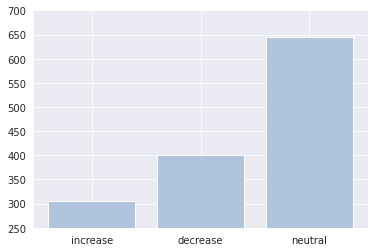

In [ ]:
incr_counts = 0
decr_counts = 0
neutral_counts = 0

for i in df.Label:
  if i == 'increase':
    incr_counts += 1
  elif i == 'decrease':
    decr_counts += 1

neutral_counts = len(df) - (incr_counts + decr_counts)

counts = [incr_counts, decr_counts, neutral_counts]
labs = ['increase', 'decrease', 'neutral']

sns.set_style('darkgrid')
color = 'lightsteelblue'

plt.bar(labs, counts, color = color)
plt.ylim([250, 700])
plt.show()

## Model import and configuration

In [ ]:
# importing model
bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',
                                                          num_labels = 3)
config = bert.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#changing labels
config.max_position_embeddings = 200
config.id2label[0] = 'decrease'
config.id2label[1] = 'neutral'
config.id2label[2] = 'increase'
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "decrease",
    "1": "neutral",
    "2": "increase"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 200,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
config.label2id['decrease'] = config.label2id['LABEL_0']
config.label2id['neutral'] = config.label2id['LABEL_1']
config.label2id['increase'] = config.label2id['LABEL_2']
del config.label2id['LABEL_0']
del config.label2id['LABEL_1']
del config.label2id['LABEL_2']
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "decrease",
    "1": "neutral",
    "2": "increase"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "decrease": 0,
    "increase": 2,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 200,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
# importing tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast = True)

In [ ]:
tokenizer.model_max_length = 200
tokenizer.model_max_length

200

In [ ]:
batch_size = 16
epochs = 5
lr = 2e-5
early_stopping = early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 1,
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)
auto = tf.data.experimental.AUTOTUNE
max_seq_length = 200

## Tokenizing data

In [ ]:
x = df.Filing.values
y = df.Label.values
labs = []

for i in y:
  if i == 'decrease':
    labs.append(0)
  elif i == 'neutral':
    labs.append(1)
  else:
    labs.append(2)
labs = np.array(labs)
x_train, x_test, y_train, y_test = train_test_split(x, labs, test_size = 0.2, random_state = 42)

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(x_train, y_train, test_size =0.2)

In [ ]:
train_encodings = tokenizer(list(train_texts),
                            truncation = True,
                            padding = True,
                            max_length = max_seq_length,
                            return_tensors = 'pt')

val_encodings = tokenizer(list(val_texts),
                          truncation = True,
                          padding = True,
                          max_length = max_seq_length,
                          return_tensors = 'pt')

test_encodings = tokenizer(list(x_test),
                           truncation = True,
                           padding = True,
                           return_tensors = 'pt')

In [ ]:
class SEC_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SEC_Dataset(train_encodings, train_labels)
val_dataset = SEC_Dataset(val_encodings, val_labels)
test_dataset = SEC_Dataset(test_encodings, y_test)

## Performance metrics

In [ ]:
# custom metrics
def compute_metrics(eval_pred):
  labels = eval_pred.label_ids
  preds = eval_pred.predictions.argmax(-1)
  lab_names = [0,1,2]
  
  precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average ='weighted')
  acc = accuracy_score(labels, preds)
  print(precision_recall_fscore_support(labels, preds, average = None, labels = lab_names))

  dic = {
      'Accuracy': acc,
      'F1': f1,
      'Precision': precision,
      'Recall': recall,
      'Support': support
  }
  return dic

## Training

In [ ]:
# overriding trainer class to log metrics during training --> evaluate overfitting
class MyTrainer(Trainer):
  def __init__(self, model,
        args = None,
        data_collator = None,
        train_dataset = None,
        eval_dataset = None,
        tokenizer = None,
        model_init = None,
        compute_metrics = None,
        callbacks = None,
        optimizers = (None,None)
    ):

    super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init,
                  compute_metrics, callbacks, optimizers) 
    
  def evaluate(
        self,
        train_dataset = None,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
    ) -> Dict[str, float]:
        
        # memory metrics - must set up as early as possible
        self._memory_tracker.start()

        if eval_dataset is not None and not isinstance(eval_dataset, collections.abc.Sized):
            raise ValueError("eval_dataset must implement __len__")

        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        start_time = time.time()

        train_output = self.prediction_loop(
            train_dataloader,
            description = 'Training',
            prediction_loss_only = True if self.compute_metrics is None else None,
            ignore_keys = ignore_keys,
            metric_key_prefix = 'train',
            )


        eval_output = self.prediction_loop(
            eval_dataloader,
            description="Evaluation",
            # No point gathering the predictions if there are no metrics, otherwise we defer to
            # self.args.prediction_loss_only
            prediction_loss_only=True if self.compute_metrics is None else None,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix,
        )
        train_n_samples = len(self.train_dataset)
        train_output.metrics.update(speed_metrics('train', start_time, train_n_samples))
        self.log(train_output.metrics)

        eval_n_samples = len(eval_dataset if eval_dataset is not None else self.eval_dataset)
        eval_output.metrics.update(speed_metrics(metric_key_prefix, start_time, eval_n_samples))
        self.log(eval_output.metrics)

        if self.args.tpu_metrics_debug or self.args.debug:
            # tpu-comment: Logging debug metrics for PyTorch/XLA (compile, execute times, ops, etc.)
            xm.master_print(met.metrics_report())
        
        train_output.metrics['eval_loss'] = 'No log'
        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, eval_output.metrics)
        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, train_output.metrics)

        self._memory_tracker.stop_and_update_metrics(train_output.metrics)
        self._memory_tracker.stop_and_update_metrics(eval_output.metrics)

        dic = {
        'Training metrics': train_output.metrics,
        'Validation metrics': eval_output.metrics
        }

        return dic



<b>NOTE</b> below two rows per epoch are reported since it prints one row for the evaluation, and one row for training. That's why there is no log in the second row for validation loss, and why the training loss is the same for the two rows. 

In [ ]:
training_args = TrainingArguments(
    output_dir = 'BERT',
    num_train_epochs = epochs,
    do_train = True,
    do_eval = True,
    evaluation_strategy = 'epoch',
    logging_strategy = 'epoch',
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    warmup_steps = 250,
    weight_decay = 0.01
)

trainer = MyTrainer(
    model = bert,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Support
1,1.017700,0.991621,0.532407,0.514153,0.606120,0.532407,None
1,1.017700,No log,0.598380,0.574733,0.642952,0.598380,None
2,0.916000,0.869617,0.666667,0.651727,0.692518,0.666667,None
2,0.916000,No log,0.697917,0.679535,0.716436,0.697917,None
3,0.822000,0.813070,0.675926,0.666547,0.693956,0.675926,None
3,0.822000,No log,0.730324,0.721669,0.757793,0.730324,None
4,0.731000,0.699046,0.675926,0.670050,0.708773,0.675926,None
4,0.731000,No log,0.784722,0.774019,0.804240,0.784722,None
5,0.639600,0.673265,0.740741,0.736145,0.785544,0.740741,None
5,0.639600,No log,0.818287,0.809384,0.838963,0.818287,None


/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:367: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Tranformers.
  FutureWarning,


(array([0.50228311, 0.59965338, 0.89705882]), array([0.44897959, 0.8377724 , 0.2961165 ]), array([0.47413793, 0.6989899 , 0.44525547]), array([245, 413, 206]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.52542373, 0.4893617 , 0.9375    ]), array([0.3974359 , 0.78409091, 0.3       ]), array([0.45255474, 0.60262009, 0.45454545]), array([78, 88, 50]))
(array([0.70408163, 0.67433628, 0.81553398]), array([0.56326531, 0.92251816, 0.40776699]), array([0.62585034, 0.7791411 , 0.54368932]), array([245, 413, 206]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.703125  , 0.62204724, 0.8       ]), array([0.57692308, 0.89772727, 0.4       ]), array([0.63380282, 0.73488372, 0.53333333]), array([78, 88, 50]))
(array([0.60233918, 0.80668258, 0.84466019]), array([0.84081633, 0.81840194, 0.4223301 ]), array([0.70187394, 0.8125    , 0.5631068 ]), array([245, 413, 206]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.61165049, 0.72413793, 0.76923077]), array([0.80769231, 0.71590909, 0.4       ]), array([0.6961326 , 0.72      , 0.52631579]), array([78, 88, 50]))
(array([0.68932039, 0.82182628, 0.90566038]), array([0.86938776, 0.89346247, 0.46601942]), array([0.76895307, 0.85614849, 0.61538462]), array([245, 413, 206]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.6344086 , 0.65656566, 0.91666667]), array([0.75641026, 0.73863636, 0.44      ]), array([0.69005848, 0.69518717, 0.59459459]), array([78, 88, 50]))
(array([0.88479263, 0.76470588, 0.93333333]), array([0.78367347, 0.97578692, 0.54368932]), array([0.83116883, 0.85744681, 0.68711656]), array([245, 413, 206]))


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "train/train_Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/Support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


(array([0.85483871, 0.64285714, 0.92857143]), array([0.67948718, 0.92045455, 0.52      ]), array([0.75714286, 0.75700935, 0.66666667]), array([78, 88, 50]))


TrainOutput(global_step=270, training_loss=0.8252539458098235, metrics={'train_runtime': 274.0148, 'train_samples_per_second': 0.985, 'total_flos': 567567891648000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 2638450688, 'init_mem_gpu_alloc_delta': 439075328, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 12742656, 'train_mem_gpu_alloc_delta': 1326974464, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 3255743488})

In [ ]:
trainer.state.log_history

[{'epoch': 1.0, 'learning_rate': 1.08e-05, 'loss': 1.0177, 'step': 54},
 {'epoch': 1.0,
  'step': 54,
  'train_Accuracy': 0.5983796296296297,
  'train_F1': 0.5747329272262763,
  'train_Precision': 0.6429517640411481,
  'train_Recall': 0.5983796296296297,
  'train_Support': None,
  'train_loss': 0.9573676586151123,
  'train_runtime': 15.1288,
  'train_samples_per_second': 57.11},
 {'epoch': 1.0,
  'eval_Accuracy': 0.5324074074074074,
  'eval_F1': 0.5141532892863654,
  'eval_Precision': 0.6061198177532021,
  'eval_Recall': 0.5324074074074074,
  'eval_Support': None,
  'eval_loss': 0.9916209578514099,
  'eval_runtime': 15.1313,
  'eval_samples_per_second': 14.275,
  'step': 54},
 {'epoch': 2.0, 'learning_rate': 2.16e-05, 'loss': 0.916, 'step': 108},
 {'epoch': 2.0,
  'step': 108,
  'train_Accuracy': 0.6979166666666666,
  'train_F1': 0.6795354275543437,
  'train_Precision': 0.716436209439528,
  'train_Recall': 0.6979166666666666,
  'train_Support': None,
  'train_loss': 0.8049808144569397,

## Plotting training

In [ ]:
for log_history in trainer.state.log_history:
  print(log_history.keys())

dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_Support', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'eval_Support', 'eval_runtime', 'eval_samples_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_Support', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'eval_Support', 'eval_runtime', 'eval_samples_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_Support', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict

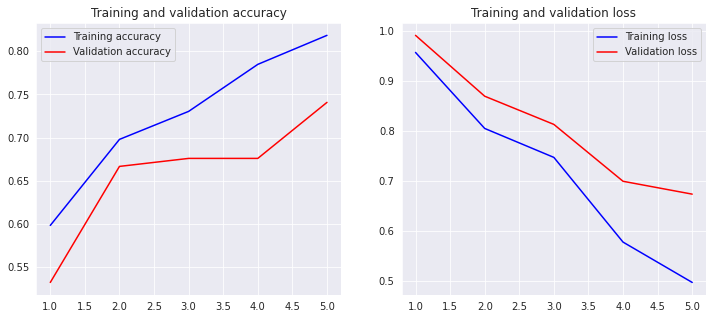

In [ ]:
train_loss = []
eval_loss = []
eval_acc = []
train_acc = []

for log_history in trainer.state.log_history:

  if 'train_loss' in log_history.keys():
    train_loss.append(log_history['train_loss'])
    train_acc.append(log_history['train_Accuracy'])
    
  elif 'eval_loss' in log_history.keys():
    eval_loss.append(log_history['eval_loss'])
    eval_acc.append(log_history['eval_Accuracy'])

x = range(1, len(train_acc) + 1)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(x, train_acc, 'b', label = 'Training accuracy')
plt.plot(x, eval_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x, train_loss, 'b', label = 'Training loss')
plt.plot(x, eval_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
print(eval_loss, eval_acc)

[0.9916209578514099, 0.8696171641349792, 0.8130695223808289, 0.6990460753440857, 0.6732652187347412] [0.5324074074074074, 0.6666666666666666, 0.6759259259259259, 0.6759259259259259, 0.7407407407407407]
